## Imports

In [1]:
import lenstronomy

lenstronomy.__version__

'1.9.3'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc
from tqdm import tnrange

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import paperfig as pf

pf.set_fontscale(2.)

import sys
sys.path.insert(0, './process_output')

from output_class import *
# to load the custom_log_likelihood function for unpickling

savefig = False

# Load output files

In [4]:
composite_files = [
    '2038_run205_1_0_0_0_0_shortened',
    '2038_run205_1_0_1_0_0_shortened',
    '2038_run205_1_0_2_0_0_shortened',
    '2038_run205_1_1_0_0_0_shortened',
    '2038_run205_1_1_1_0_0_shortened',
    '2038_run205_1_1_2_0_0_shortened',
    
    '2038_run206_1_0_0_0_0_shortened',
    '2038_run206_1_0_1_0_0_shortened',
    '2038_run206_1_0_2_0_0_shortened',
    '2038_run206_1_1_0_0_0_shortened',
    '2038_run206_1_1_1_0_0_shortened',
    '2038_run206_1_1_2_0_0_shortened',
    
#     '2038_run178_1_0_0_0_0_shortened',
#     '2038_run178_1_0_1_0_0_shortened',
#     '2038_run178_1_0_2_0_0_shortened',
#     '2038_run178_1_1_0_0_0_shortened',
#     '2038_run178_1_1_1_0_0_shortened',
#     '2038_run178_1_1_2_0_0_shortened',
    
#     '2038_run179_1_0_0_0_0_shortened',
#     '2038_run179_1_0_1_0_0_shortened',
#     '2038_run179_1_0_2_0_0_shortened',
#     '2038_run179_1_1_0_0_0_shortened',
#     '2038_run179_1_1_1_0_0_shortened',
#     '2038_run179_1_1_2_0_0_shortened',
]

In [5]:
composite_bics = []
composite_param_arrays = []
composite_num_param_arrays = []
composite_kwargs_models = []
composite_kwargs_constraints = []
composite_param_classes = []
composite_lens_models = []
composite_kwargs_likelihoods = []
composite_multi_band_list = []

for job_name_out in composite_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1][np.random.randint(0, high=fit_output[-1][1].shape[0], size=10000)]
    param_mcmc = fit_output[-1][2]
    
    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    composite_bics.append(bic)
    composite_param_arrays.append(np.copy(samples_mcmc))
    composite_num_param_arrays.append(len(samples_mcmc))
    composite_kwargs_models.append(kwargs_model)
    composite_kwargs_constraints.append(kwargs_constraints)
    composite_param_classes.append(param_class)
    composite_lens_models.append(lens_model)
    composite_kwargs_likelihoods.append(kwargs_likelihood)
    composite_multi_band_list.append(multi_band_list_out)
    
    gc.collect()
    #break

## Compute BIC weights and combine models

In [6]:
len(composite_kwargs_models)

12

In [7]:
# from the notebook "Fermat potentials and lens model comparisons"
sigma_numeric_bic, sigma_model_bic = 69.05339424569138, 237.25336211795366

In [8]:
num_sample = 500

In [9]:
composite_r200s = []
composite_M200s = []
composite_c200s = []

stellar_masses = []
dm_fraction = []

total_masses_within_0p2_arcsec = []

lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

composite_weights = get_relative_weights(composite_bics, sigma_model_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)    

for n_job in tnrange(len(composite_files), desc='Jobs:'):
    
    r200s, M200s, c200s = [], [], []
    stellar_mass = []
    total_mass_within_0p2_arcsec = []
    
    num_sample_from_job = int(num_sample * composite_weights[n_job])
    
    sampled_indices = np.random.randint(low=0, high=composite_num_param_arrays[n_job], size=num_sample_from_job)
    
    lens_model = composite_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models[n_job])
    
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        param_array = composite_param_arrays[n_job][sampled_indices[i]]

        param_class = composite_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']

        _, _, c, r, M = lens_cosmo.nfw_angle2physical(lens_result[0]['Rs'], lens_result[0]['alpha_Rs'])
        
        r = c * lens_result[0]['Rs']
        
        # stellar mass
        r_half_light = 3.2
        mean_convergence = lens_analysis.mass_fraction_within_radius(lens_result, 
                                                                 lens_result[0]['center_x'], 
                                                                 lens_result[0]['center_y'], 
                                                                 r_half_light, numPix=320) # using half-light radius
        
        stellar_mass.append(np.log10(2 * mean_convergence[2] * np.pi 
                              * (r_half_light/206265 * lens_cosmo.dd)**2 * lens_cosmo.sigma_crit))

        
        theta_E = lens_analysis.effective_einstein_radius(lens_result, verbose=False)
        
        ## dm_fraction
        mass_fraction = lens_analysis.mass_fraction_within_radius(lens_result, 
                                                                 lens_result[0]['center_x'], 
                                                                 lens_result[0]['center_y'], 
                                                                 theta_E, numPix=320) # using half-light radius
        
        dm_fraction.append(mass_fraction[0] / (mass_fraction[0] + mass_fraction[2]))
        
        # total mass in the central 0.2"
        _r = 0.2
        _mean_convergence = lens_analysis.mass_fraction_within_radius(lens_result, 
                                                                 lens_result[0]['center_x'], 
                                                                 lens_result[0]['center_y'], 
                                                                 _r, numPix=100)
       
        
        
        total_mass_within_0p2_arcsec.append(np.log10((_mean_convergence[0]+_mean_convergence[2]) * np.pi 
                                      * (_r/206265 * lens_cosmo.dd)**2 * lens_cosmo.sigma_crit))
        
        
        
        r200s.append(r)
        M200s.append(M)
        c200s.append(c)
        

    composite_r200s += r200s
    composite_M200s += M200s
    composite_c200s += c200s
    stellar_masses += stellar_mass
    total_masses_within_0p2_arcsec += total_mass_within_0p2_arcsec

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_47891/1987961454.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n_job in tnrange(len(composite_files), desc='Jobs:'):


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_47891/1987961454.py:28: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):


Sample from job 0::   0%|          | 0/183 [00:00<?, ?it/s]

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Sample from job 1::   0%|          | 0/317 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/500 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/157 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/250 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/492 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11::   0%|          | 0/1 [00:00<?, ?it/s]

dm fraction: 0.24+0.06-0.02


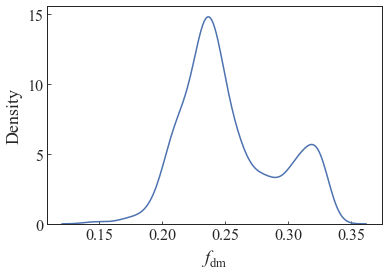

In [10]:
%matplotlib inline 

l, m, h = np.percentile(dm_fraction, q=[16, 50, 84])
print('dm fraction: {:.2f}+{:.2f}-{:.2f}'.format(m, h-m, m-l))

sns.kdeplot(dm_fraction)
plt.xlabel(r'$f_{\rm dm}$')
plt.show()

### NFW ellipticities

In [11]:
lens_result[0]

{'Rs': 22.53365614848879,
 'alpha_Rs': 1.0116550570809484,
 'e1': -0.17743366441342115,
 'e2': -0.07188417759686229,
 'center_x': -0.22539903007747178,
 'center_y': -0.04576942102128357}

In [61]:
e1s, e2s = [], []
Rss, alpha_Rss = [], []

g1s, g2s = [], []

for n_job in tnrange(len(composite_files), desc='Jobs:'):
    num_sample_from_job = int(num_sample * composite_weights[n_job])
    sampled_indices = np.random.randint(low=0, high=composite_num_param_arrays[n_job], size=num_sample_from_job)
    
    lens_model = composite_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models[n_job])

    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        param_array = composite_param_arrays[n_job][sampled_indices[i]]

        param_class = composite_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']

        e1s.append(lens_result[0]['e1'])
        e2s.append(lens_result[0]['e2'])
        
        g1s.append(lens_result[1]['gamma1'])
        g2s.append(lens_result[1]['gamma2'])
        
        Rss.append(lens_result[0]['Rs'])
        alpha_Rss.append(lens_result[0]['alpha_Rs'])

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_47891/4269664818.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n_job in tnrange(len(composite_files), desc='Jobs:'):


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_47891/4269664818.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):


Sample from job 0::   0%|          | 0/183 [00:00<?, ?it/s]

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Sample from job 1::   0%|          | 0/317 [00:00<?, ?it/s]

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Sample from job 2::   0%|          | 0/500 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/157 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/250 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/492 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11::   0%|          | 0/1 [00:00<?, ?it/s]

[0.72253629 0.76033679 0.78369734]


<AxesSubplot:ylabel='Density'>

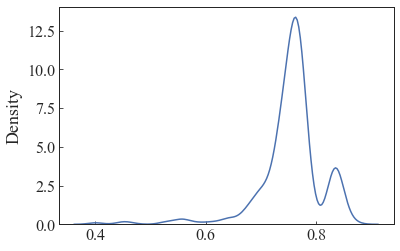

In [13]:
from lenstronomy.Util.param_util import ellipticity2phi_q

phis, qs = ellipticity2phi_q(np.array(e1s), np.array(e2s))

print(np.percentile(qs, q=[16, 50, 84]))
sns.kdeplot(qs)

Text(0.5, 1.0, 'NFW convergence')

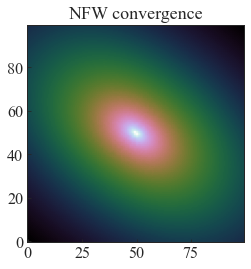

In [14]:
from lenstronomy.LensModel.lens_model import LensModel

lens_model = LensModel(['NFW_ELLIPSE'])

w = 2
x = np.linspace(-w, w, 100)
y = np.linspace(-w, w, 100)

xx, yy = np.meshgrid(x, y)

kwargs = [{
    'e1': np.median(e1s),
    'e2': np.median(e2s),
    'Rs': np.median(Rss),
    'alpha_Rs': np.median(alpha_Rss),
    'center_x': 0., 'center_y': 0.
}]

convergence = lens_model.kappa(xx, yy, kwargs)

plt.imshow(np.log10(convergence), origin='lower', cmap='cubehelix')
plt.title('NFW convergence')

In [29]:
ellipticity2phi_q(np.median(e1s), np.median(e2s))

from lenstronomy.Util.param_util import phi_q2_ellipticity, ellipticity2phi_q, shear_cartesian2polar

phi_q2_ellipticity(0, 0.7572273426392357)

(0.13815665820231107, 0.0)

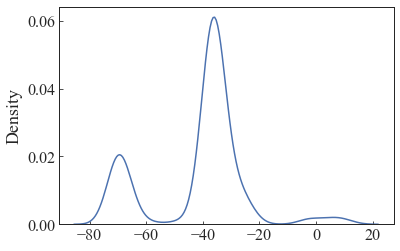

$-35.8^{+3.4}_{2.3}$


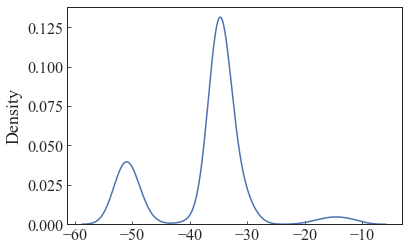

$-55.3^{+0.9}_{-1.4}$


In [64]:
phis, qs = ellipticity2phi_q(np.array(e1s), np.array(e2s))
phis *= 180 / np.pi

sns.kdeplot(phis)
plt.show()

phis  = phis[(phis < -15) & (phis > -55)]
l, m, h = np.percentile(phis, q=[16, 50, 84])
print('${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$'.format(m, h-m, m-l))


phis, qs = shear_cartesian2polar(np.array(g1s), np.array(g2s))
phis *= 180 / np.pi

sns.kdeplot(phis)
plt.show()

phis  = phis[(phis < -20) & (phis > -48)]
l, m, h = np.percentile(-phis - 90, q=[16, 50, 84])
print('${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$'.format(m, h-m, m-l))


<AxesSubplot:ylabel='Density'>

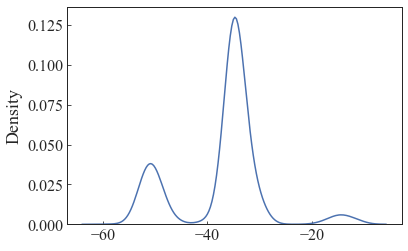

In [32]:
sns.kdeplot(phis*180/np.pi)


# Plot

Cosmology "my_cosmo" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0500, H0 = 70.00, sigma8 = 0.8230, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Removed no burn in


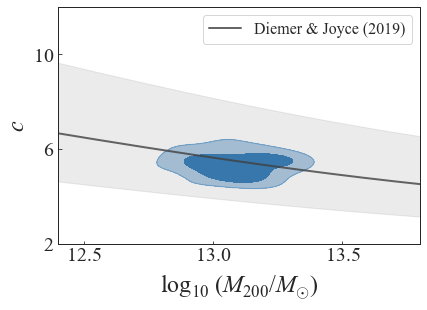

In [16]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from chainconsumer import ChainConsumer

from getdist import plots
from getdist import MCSamples

#cosmology.setCosmology('planck15');

#my_cosmo = {'flat': True, 'H0': 67.8, 'Om0': 0.3, 'Ob0': 0.05, 'sigma8': 0.823, 'ns': 0.96} # cosmo to match with Behroozi et al. 2019
my_cosmo = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.05, 'sigma8': 0.823, 'ns': 0.96} # fiducial cosmo
my_cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

print(my_cosmo)
#print(cosmo)

z_l = 0.23
z_s = 0.777

#rho0, Rs, c, r200, M200 = lens_cosmo.nfw_angle2physical(samples_mcmc[:, 4], samples_mcmc[:, 5])

Ms = np.logspace(12., 14.6, 200)
c200_th = concentration.concentration(Ms*my_cosmo.h, '200c', z_l, model='diemer19')

mc_samples = MCSamples(samples=[np.log10(composite_M200s).flatten(), 
                                np.squeeze(composite_c200s).flatten()], 
                       names=['M200', 'c200'], 
                       labels=['\\log_{10} (M_{200}/M_{\odot})', 'c_{200}'])
mc_samples.updateSettings({'smooth_scale_2D': 0.6})

g = plots.getSinglePlotter()
#mc_samples.updateSettings({'contours': [0.3934693, 0.8646647, 0.9888910, 0.9996645, 0.9999963]})
mc_samples.updateSettings({'contours': [0.68, 0.95, 0.99]})

g.settings.num_plot_contours = 2
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 24

g.plot_2d(mc_samples, 'M200', 'c200', shaded=False, filled=True,
          line_args=[{'ls':'-', 'color': pf.cb_blue}]
         );

ax = g.fig.gca()

# g.fig.tight_layout()

ax.plot(np.log10(Ms), c200_th, color=pf.cb_grey, label='Diemer & Joyce (2019)', alpha=0.8, lw=2)
ax.fill_between(np.log10(Ms), 10**(np.log10(c200_th)+0.16), 10**(np.log10(c200_th)-0.16), alpha=0.1,  
                 color=pf.cb_grey)


    
ax.set_xlabel(r'$\log_{10}\ (M_{200}/M_{\odot})$')
ax.set_xlim(12.4, 13.8)
ax.set_ylim(2, 12)
ax.set_ylabel(r'$c$')
#ax.set_title('Central deflector\'s $M$-$c$ relation')
ax.legend()

if savefig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/m_c_relation.pdf', bbox_inches='tight')

g.fig;

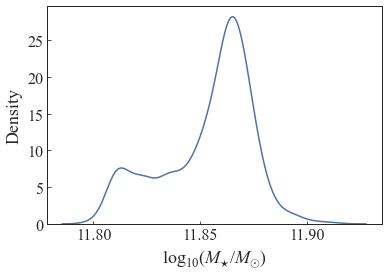

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.kdeplot(stellar_masses, ax=ax)
ax.set_xlabel('$\log_{10} (M_{\star}/M_{\odot})$')

fig;

In [18]:
low, med, hi = np.percentile(stellar_masses, q=[16, 50, 84])

print(med, '+', hi-med, '-', med-low)

11.860435067759013 + 0.011240491355328786 - 0.03382917369870775


In [19]:
low, med, hi = np.percentile(np.log10(composite_M200s).flatten(), q=[16, 50, 84])

print(med, '+', hi-med, '-', med-low)

13.090074912397817 + 0.12227111450683381 - 0.12970101946079282


In [20]:
low, med, hi = np.percentile(10**np.array(stellar_masses)/np.array(composite_M200s).flatten(), q=[16, 50, 84])

print(med, '+', hi-med, '-', med-low)

0.05846136354576034 + 0.022604709270137593 - 0.01672938721655535


## Radial profile of NFW and stellar mass

In [21]:
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis


lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

composite_weights = get_relative_weights(composite_bics, sigma_model_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)    

dark_mass_profiles = []
light_mass_profiles = []

for n_job in tnrange(len(composite_files), desc='Jobs:'):
    num_sample_from_job = int(num_sample * composite_weights[n_job])
    
    sampled_indices = np.random.randint(low=0, high=composite_num_param_arrays[n_job], size=num_sample_from_job)
    
    lens_model = composite_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models[n_job])
    
    lens_profile = LensProfileAnalysis(lens_model)
    
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        r = np.logspace(-2, 1, 100)
        
        param_array = composite_param_arrays[n_job][sampled_indices[i]]

        param_class = composite_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']
        
        dark_mass, light_mass = [], []
        
        center_x, center_y = lens_result[0]['center_x'], lens_result[0]['center_y']
        
        for _r in r:
            dm, _, lm = lens_profile.mass_fraction_within_radius(lens_result, center_x, center_y, _r)
            dark_mass.append(dm)
            light_mass.append(lm)
        
        dark_mass_profiles.append(dark_mass) #lens_profile.radial_lens_profile(r, lens_result, model_bool_list=[0]))
        light_mass_profiles.append(light_mass) #lens_profile.radial_lens_profile(r, lens_result, model_bool_list=[2]))
        

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/183 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Sample from job 1::   0%|          | 0/318 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/500 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/157 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/252 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/493 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11::   0%|          | 0/1 [00:00<?, ?it/s]

### powerlaw profiles

In [22]:
powerlaw_files = [
    '2038_run145_0_0_0_0_0_shortened',
    '2038_run145_0_0_1_0_0_shortened',
    '2038_run145_0_0_2_0_0_shortened',
    '2038_run145_0_1_0_0_0_shortened',
    '2038_run145_0_1_1_0_0_shortened',
    '2038_run145_0_1_2_0_0_shortened',
    
    '2038_run146_0_0_0_0_0_shortened',
    '2038_run146_0_0_1_0_0_shortened',
    '2038_run146_0_0_2_0_0_shortened',
    '2038_run146_0_1_0_0_0_shortened',
    '2038_run146_0_1_1_0_0_shortened',
    '2038_run146_0_1_2_0_0_shortened',
]

In [23]:
powerlaw_bics = []
powerlaw_param_arrays = []
powerlaw_num_param_arrays = []
powerlaw_kwargs_models = []
powerlaw_kwargs_constraints = []
powerlaw_param_classes = []
powerlaw_lens_models = []
powerlaw_kwargs_likelihoods = []
powerlaw_multi_band_list = []
powerlaw_kwargs_joint = []

for job_name_out in powerlaw_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
  
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]
    
    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    powerlaw_bics.append(bic)
    powerlaw_param_arrays.append(np.copy(samples_mcmc))
    powerlaw_num_param_arrays.append(len(samples_mcmc))
    powerlaw_kwargs_models.append(kwargs_model)
    powerlaw_kwargs_constraints.append(kwargs_constraints)
    powerlaw_param_classes.append(param_class)
    powerlaw_lens_models.append(lens_model)
    powerlaw_kwargs_likelihoods.append(kwargs_likelihood)
    powerlaw_multi_band_list.append(multi_band_list_out)
    powerlaw_kwargs_joint.append(kwargs_joint)
    
    gc.collect()
    #break

In [24]:
lens_result

[{'Rs': 23.52537708099213,
  'alpha_Rs': 1.0141572103779926,
  'e1': 0.05782180408194992,
  'e2': -0.049763023078383116,
  'center_x': -0.19636965111755,
  'center_y': -0.22901435653003088},
 {'gamma1': 0.05599281518285005,
  'gamma2': -0.08912851782365613,
  'ra_0': 0,
  'dec_0': 0},
 {'alpha_1': 1.0899043113245634,
  'ratio12': 0.9373686339645158,
  'ratio13': 10.798209430841915,
  'w_c1': 0.06867231437552884,
  'w_t1': 0.5029342108591024,
  'e11': -0.08250726501488445,
  'e21': 0.2761880655993909,
  'w_c2': 0.26627750659214744,
  'w_t2': 4.928664072061259,
  'e12': -0.006147893418925653,
  'e22': 0.08636027694270323,
  'w_c3': 1.462790939246777,
  'w_t3': 1.9102619306260873,
  'e13': -0.12866585551283513,
  'e23': 0.2722296142257001,
  'center_x': -0.004837870390506768,
  'center_y': -0.006977465945277211}]

### Mass difference between PL and composite within 0.2 arcsec

In [25]:
pl_masses_0p2_arcsec = []
#dm_fraction = []

lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

pl_weights = get_relative_weights(powerlaw_bics, sigma_model_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)    

for n_job in tnrange(len(powerlaw_files), desc='Jobs:'):
    
    r200s, M200s, c200s = [], [], []
    pl_mass = []
    
    num_sample_from_job = int(num_sample * pl_weights[n_job])
    
    sampled_indices = np.random.randint(low=0, high=powerlaw_num_param_arrays[n_job], size=num_sample_from_job)
    
    lens_model = powerlaw_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(powerlaw_lens_models[n_job])
    
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        param_array = powerlaw_param_arrays[n_job][sampled_indices[i]]

        param_class = powerlaw_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']

#         _, _, c, r, M = lens_cosmo.nfw_angle2physical(lens_result[0]['Rs'], lens_result[0]['alpha_Rs'])
        
#         r = c * lens_result[0]['Rs']
        
#         mean_convergence = lens_analysis.mass_fraction_within_radius(lens_result, 
#                                                                  lens_result[0]['center_x'], 
#                                                                  lens_result[0]['center_y'], 
#                                                                  3.2, numPix=320) # using half-light radius
        
#         theta_E = lens_analysis.effective_einstein_radius(lens_result, verbose=False)
        _r = 0.2
        _mean_convergence = lens_analysis.mass_fraction_within_radius(lens_result, 
                                                                 lens_result[0]['center_x'], 
                                                                 lens_result[0]['center_y'], 
                                                                 _r, numPix=100)
       
        
        #dm_fraction.append(mass_fraction[0] / (mass_fraction[0] + mass_fraction[2]))
        
        
        pl_mass.append(np.log10((_mean_convergence[0] + _mean_convergence[1]) * np.pi 
                                      * (_r/206265 * lens_cosmo.dd)**2 * lens_cosmo.sigma_crit))
        
        #print(mean_convergence)
        
        
#         r200s.append(r)
#         M200s.append(M)
#         c200s.append(c)
        

#     composite_r200s += r200s
#     composite_M200s += M200s
#     composite_c200s += c200s
    pl_masses_0p2_arcsec += pl_mass

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/139 [00:00<?, ?it/s]

Sample from job 1::   0%|          | 0/363 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/473 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/184 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/377 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/500 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11:: 0it [00:00, ?it/s]

In [26]:
_len = min(len(pl_masses_0p2_arcsec), len(total_masses_within_0p2_arcsec))

np.log10(np.mean(10**(np.array(pl_masses_0p2_arcsec[:_len])) - (10**(np.array(total_masses_within_0p2_arcsec[:_len]) ))))

10.580844751402065

In [27]:
10**.580495828900494

3.806237019550362

In [28]:
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.class_creator as class_creator


lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

powerlaw_weights = get_relative_weights(powerlaw_bics, sigma_model_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)    

powerlaw_profiles = []
sersic_profiles = []


for n_job in tnrange(len(composite_files), desc='Jobs:'):
    num_sample_from_job = int(num_sample * powerlaw_weights[n_job])
    
    sampled_indices = np.random.randint(low=0, high=powerlaw_num_param_arrays[n_job], size=num_sample_from_job)
    
    lens_model = powerlaw_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(powerlaw_lens_models[n_job])

    lens_profile = LensProfileAnalysis(lens_model)
    
    kwargs_model = powerlaw_kwargs_models[n_job]
    
    light_model = LightModel(kwargs_model['lens_light_model_list'])
    light_analysis = LightProfileAnalysis(light_model)
    
    
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        r = np.logspace(-2, 1, 100)
        
        param_array = powerlaw_param_arrays[n_job][sampled_indices[i]]

        param_class = powerlaw_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']
        
        mass = []
        
        center_x, center_y = lens_result[0]['center_x'], lens_result[0]['center_y']
        
        for _r in r:
            m = lens_profile.mass_fraction_within_radius(lens_result, center_x, center_y, _r)[0]
            mass.append(m)
            
        powerlaw_profiles.append(mass) #lens_profile.radial_lens_profile(r, lens_result, model_bool_list=[0]))
        
        #print(powerlaw_kwargs_joint)
        ## linear-solve light profiles
#         image_model = class_creator.create_im_sim(powerlaw_multi_band_list[n_job],
#                                                   powerlaw_kwargs_joint[n_job]['multi_band_type'],
#                                                   powerlaw_kwargs_models[n_job],
#                                                   bands_compute=None,
#                                                   likelihood_mask_list=powerlaw_kwargs_likelihoods[n_job][
#                                                         'image_likelihood_mask_list'],
#                                                   band_index=2)

#         model, error_map, cov_param, param = image_model.image_linear_solve(
#                                                                     inv_bool=True,
#                                                                     **kwargs_result)
        
#         sersic_profiles.append(light_analysis.radial_light_profile(r, kwargs_result['kwargs_lens_light'], 
#                                                                 model_bool_list=[6, 7, 8]))
        

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  app.launch_new_instance()


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/140 [00:00<?, ?it/s]

Sample from job 1::   0%|          | 0/362 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/474 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/183 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/378 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/500 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11:: 0it [00:00, ?it/s]

In [29]:
amps = np.array([ 109.71266358,  794.93301916, 1532.92674307, 2512.27225728,
         802.3082921 , 1541.40433211, 2247.26031178, 3461.27666923,
        1438.18065661])
sigmas = np.array([ 0.11148307,  0.2444676 ,  0.52249641,  1.04108547,  2.20575275,
         2.21091594,  3.72653489,  8.49165874, 10.99787672])
    
mge_profile = 0.

xs = np.logspace(-2.5, 1.5, 1000)

for a, s in zip(amps, sigmas):
    mge_profile += a / (2*np.pi) / s**2 * np.exp(-xs**2/2./s**2) * 0.08**2

#amp = interp1d(xs, mge_profile)(3.2) * 8.

isophote_intensity = np.array([2.81674395e+01, 2.80241003e+01, 2.79376548e+01, 2.76640070e+01,
       2.73205135e+01, 2.69109445e+01, 2.65524359e+01, 2.63234559e+01,
       2.61003984e+01, 2.57406847e+01, 2.53513680e+01, 2.48909097e+01,
       2.43021945e+01, 2.36588153e+01, 2.29707524e+01, 2.22451540e+01,
       2.15400730e+01, 2.07415821e+01, 1.99374879e+01, 1.88695315e+01,
       1.77770359e+01, 1.66502970e+01, 1.56436536e+01, 1.44859412e+01,
       1.33254826e+01, 1.21847738e+01, 1.10139487e+01, 9.99849327e+00,
       8.97374038e+00, 8.03202159e+00, 7.10128401e+00, 6.18937208e+00,
       5.41697295e+00, 4.70240938e+00, 4.03017982e+00, 3.42997255e+00,
       3.04799056e+00, 3.00171312e+00, 2.44105927e+00, 1.80370421e+00,
       1.54964383e+00, 1.36756897e+00, 1.13430798e+00, 9.84463155e-01,
       8.27425112e-01, 6.94655303e-01, 5.82004736e-01, 4.86960530e-01,
       4.08075673e-01, 3.37802253e-01, 2.85625896e-01, 2.40198604e-01,
       2.09867513e-01, 1.82181829e-01, 1.52603805e-01, 1.19826501e-01,
       9.70260012e-02, 7.95500478e-02, 6.81121601e-02, 6.00368136e-02,
       5.03291831e-02, 3.85513013e-02, 3.32596003e-02, 2.90814516e-02,
       2.23873108e-02, 1.77987097e-02, 1.39330881e-02, 1.00113482e-02,
       7.01918292e-03, 5.42133087e-03, 4.19826941e-03])

isophote_intensity_error = np.array([0., 0.00574245, 0.01188524, 0.03156116, 0.04193748,
       0.0536408 , 0.04996095, 0.05266414, 0.07238149, 0.06346388,
       0.06492183, 0.06970633, 0.0636235 , 0.06418433, 0.06599174,
       0.05704632, 0.05398294, 0.0515921 , 0.04574281, 0.02288327,
       0.02000093, 0.02303395, 0.02613524, 0.02107169, 0.02213201,
       0.02157028, 0.01916878, 0.01388   , 0.01319626, 0.01111101,
       0.00981156, 0.01179084, 0.00655008, 0.00820663, 0.00967259,
       0.01268297, 0.02594064, 0.06587547, 0.03746649, 0.01448655,
       0.02300083, 0.0180416 , 0.00799866, 0.00764895, 0.0050912 ,
       0.00396138, 0.00306038, 0.00203216, 0.001653  , 0.00144987,
       0.00118027, 0.00112279, 0.00127357, 0.0008839 , 0.00081083,
       0.00053862, 0.000557  , 0.00047287, 0.00044553, 0.00044298,
       0.0005861 , 0.000408  , 0.00052336, 0.00061238, 0.00035364,
       0.00026787, 0.00020575, 0.00021654, 0.00019584, 0.00019115,
       0.00017079])

isophote_r = np.array([0.00000001e+00, 1.86065920e-01, 2.37295337e-01, 3.67813481e-01,
       5.03628292e-01, 6.43280489e-01, 7.48321392e-01, 8.21033465e-01,
       8.89143806e-01, 9.76371434e-01, 1.06646489e+00, 1.16832942e+00,
       1.28849135e+00, 1.42064486e+00, 1.56197937e+00, 1.70767846e+00,
       1.86021302e+00, 2.03406115e+00, 2.20326176e+00, 2.42183240e+00,
       2.65492841e+00, 2.90810204e+00, 3.16905497e+00, 3.47181721e+00,
       3.81280580e+00, 4.18338109e+00, 4.59438003e+00, 5.01392427e+00,
       5.49652467e+00, 6.01711387e+00, 6.59932646e+00, 7.27461282e+00,
       8.02031940e+00, 8.87208933e+00, 9.82524169e+00, 1.09336657e+01,
       1.19017311e+01, 1.24267750e+01, 1.40392760e+01, 1.64870054e+01,
       1.81357060e+01, 1.99492766e+01, 2.19590749e+01, 2.39588680e+01,
       2.64394268e+01, 2.90708671e+01, 3.19779538e+01, 3.50589844e+01,
       3.83696540e+01, 4.24385775e+01, 4.63596062e+01, 5.11263215e+01,
       5.56717815e+01, 6.04209085e+01, 6.62256080e+01, 7.36358778e+01,
       8.09080359e+01, 8.77657241e+01, 9.52988370e+01, 1.02375723e+02,
       1.12063918e+02, 1.24029703e+02, 1.34567850e+02, 1.46001962e+02,
       1.58627003e+02, 1.72303813e+02, 1.87616130e+02, 2.09023959e+02,
       2.34113805e+02, 2.54179001e+02, 2.72434313e+02]) * 0.08

In [30]:
r_diff = np.diff(isophote_r)

In [31]:
r_diff = np.append([0.00000001e+00], r_diff)

In [32]:
r_diff

array([1.00000000e-08, 1.48852728e-02, 4.09835336e-03, 1.04414515e-02,
       1.08651849e-02, 1.11721758e-02, 8.40327224e-03, 5.81696584e-03,
       5.44882728e-03, 6.97821024e-03, 7.20747648e-03, 8.14916240e-03,
       9.61295440e-03, 1.05722808e-02, 1.13067608e-02, 1.16559272e-02,
       1.22027648e-02, 1.39078504e-02, 1.35360488e-02, 1.74856512e-02,
       1.86476808e-02, 2.02538904e-02, 2.08762344e-02, 2.42209792e-02,
       2.72790872e-02, 2.96460232e-02, 3.28799152e-02, 3.35635392e-02,
       3.86080320e-02, 4.16471360e-02, 4.65770072e-02, 5.40229088e-02,
       5.96565264e-02, 6.81415944e-02, 7.62521888e-02, 8.86739208e-02,
       7.74452320e-02, 4.20035120e-02, 1.29000080e-01, 1.95818352e-01,
       1.31896048e-01, 1.45085648e-01, 1.60783864e-01, 1.59983448e-01,
       1.98444704e-01, 2.10515224e-01, 2.32566936e-01, 2.46482448e-01,
       2.64853568e-01, 3.25513880e-01, 3.13682296e-01, 3.81337224e-01,
       3.63636800e-01, 3.79930160e-01, 4.64375960e-01, 5.92821584e-01,
      

In [33]:
isophote_enclosed_flux = []

for i in range(len(isophote_r)):
    isophote_enclosed_flux.append(np.sum(2*np.pi * isophote_intensity[:i] * isophote_r[:i] * r_diff[:i]) / (2*np.pi*isophote_r[i]**2))    
    
    

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


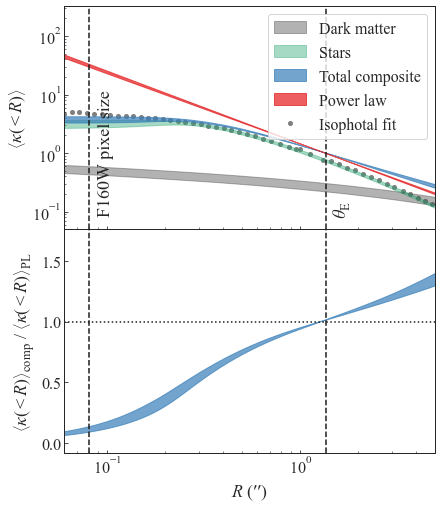

In [34]:
pf.set_fontscale(2)

fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2, height_ratio=pf.golden_ratio*2))
ax = fig.add_subplot(211)

dark_upper_quantile, dark_median, dark_lower_quantile  = np.percentile(dark_mass_profiles, q=[84, 50, 16], axis=0)
light_upper_quantile, light_median, light_lower_quantile  = np.percentile(light_mass_profiles, q=[84, 50, 16], axis=0)

from scipy.interpolate import interp1d

kappa_light_amp_at_theta_E = interp1d(r, light_median)(1.3617)
#light_amp_at_theta_E = interp1d(isophote_r, isophote_intensity)(1.3617)
light_amp_at_theta_E = interp1d(isophote_r, isophote_enclosed_flux)(1.3617)

#isophote_intensity *= kappa_light_amp_at_theta_E / light_amp_at_theta_E
isophote_enclosed_flux = np.array(isophote_enclosed_flux) * kappa_light_amp_at_theta_E / light_amp_at_theta_E
isophote_intensity_error *= kappa_light_amp_at_theta_E / light_amp_at_theta_E

composite_upper_quantile, composite_lower_quantile  = np.percentile(
    np.array(dark_mass_profiles) + np.array(light_mass_profiles), 
    q=[84, 16], axis=0)

powerlaw_upper_quantile, powerlaw_median, powerlaw_lower_quantile  = np.percentile(powerlaw_profiles, q=[84, 50, 16], axis=0)
# sersic_upper_quantile, sersic_median, sersic_lower_quantile  = np.percentile(sersic_profiles, q=[84, 50, 16], 
#                                                                              axis=0)

ax.fill_between(r, dark_upper_quantile, dark_lower_quantile, alpha=0.4, color=pf.cb_grey, label='Dark matter')
ax.fill_between(r, light_upper_quantile, light_lower_quantile, alpha=0.4, 
                color=sns.xkcd_rgb['teal green'], #pf.cb_purple, 
                label='Stars')

ax.fill_between(r, composite_upper_quantile, composite_lower_quantile, alpha=0.7, color=pf.cb_blue, label='Total composite')
ax.fill_between(r, powerlaw_upper_quantile, powerlaw_lower_quantile, alpha=0.7, color=pf.cb_red, label='Power law')

factor = (np.median(sersic_profiles, axis=0) / np.median(light_mass_profiles, axis=0))[np.argwhere(r >= 3.1)[0]]

# ax.fill_between(r, sersic_upper_quantile/factor, sersic_lower_quantile/factor, alpha=0.8, color=pf.emerald, label='Sersic fit')
# ax.plot(r, sersic_median/factor, alpha=0.8, color=sns.xkcd_rgb['teal green'], 
#         ls='--', label=r'Triple S${\rm \'e}$rsic fit')

ax.axvline(x=0.08, ls='--', c='k')
ax.text(0.08 + 0.01, 0.1, 'F160W pixel size', rotation=90)

ax.axvline(x=1.3617, ls='--', c='k')
ax.text(1.3617+0.1, 0.1, r'$\theta_{\rm E}$', rotation=90)

#ax.plot(xs, mge_profile*2e-1, c='k', ls='--', lw=2, label='Isophote fitting')
# ax.errorbar(isophote_r, isophote_intensity, yerr=isophote_intensity_error, c='grey', ls='None', 
#             marker='o', markersize=4, label='Isophotal fit', zorder=-10)
ax.plot(isophote_r[2:], isophote_enclosed_flux[2:], 
        #yerr=isophote_intensity_error, 
        c='grey', ls='None',
        marker='o', markersize=4, label='Isophotal fit', zorder=-10)


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.06, 5)
ax.set_ylim(0.05, 320)

#ax.set_xlabel(r'$R$ (arcsec)')
ax.set_ylabel(r'$\left\langle \kappa (< R) \right\rangle$')

ax.legend(loc='upper right')

## deviation plot

ax2 = fig.add_subplot(212, sharex=ax)

num_profiles = min(np.array(dark_mass_profiles).shape[0], np.array(powerlaw_files).shape[0])
composite_deviation_upper_quantile, composite_deviation_lower_quantile  = np.percentile(
    (np.array(dark_mass_profiles) + np.array(light_mass_profiles))[:num_profiles, :] / np.array(powerlaw_profiles)[:num_profiles, :] - 1., 
    q=[84, 16], axis=0)


ax2.fill_between(r, composite_deviation_upper_quantile+1, composite_deviation_lower_quantile+1, alpha=0.7, color=pf.cb_blue, label='Total composite')

# factor = (np.median(sersic_profiles, axis=0) / np.median(light_mass_profiles, axis=0))[np.argwhere(r >= 3.1)[0]]

# ax.fill_between(r, sersic_upper_quantile/factor, sersic_lower_quantile/factor, alpha=0.8, color=pf.emerald, label='Sersic fit')
# ax.plot(r, sersic_median/factor, alpha=0.8, color=sns.xkcd_rgb['teal green'], 
#         ls='--', label=r'Triple S${\rm \'e}$rsic fit')

ax2.axvline(x=0.08, ls='--', c='k')
# ax.text(0.08 - 0.015, 0.1, 'F160W pixel size', rotation=90)

ax2.axvline(x=1.3617, ls='--', c='k')
# ax.text(1.3617-0.35, 0.1, r'$\theta_{\rm E}$', rotation=90)

ax2.axhline(y=1., ls=':', c='k')
#ax.plot(xs, mge_profile*2e-1, c='k', ls='--', lw=2, label='Isophote fitting')
# ax.errorbar(isophote_r, isophote_intensity, yerr=isophote_intensity_error, c='grey', ls='None', 
#             marker='o', markersize=4, label='Isophotal fit', zorder=-10)

ax2.set_xscale('log')
#ax.set_yscale('log')

ax2.set_xlim(0.06, 5)
#ax2.set_ylim(0.0, 320)

ax2.set_xlabel(r'$R$ ($\prime\prime$)')
ax2.set_ylabel(r'$ \left\langle \kappa (<R)\right\rangle_{\rm comp}\ /\ \left\langle \kappa (<R) \right\rangle_{\rm PL} $')

#ax.legend(loc='upper right')
plt.subplots_adjust(wspace=0, hspace=0)

if True:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/lenstronomy_radial_convergence_profile.pdf', bbox_inches='tight')
#fig.savefig('/Users/ajshajib/Desktop/lenstronomy_radial_convergence_profile.pdf', bbox_inches='tight')

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'required M/L gradient exponent')

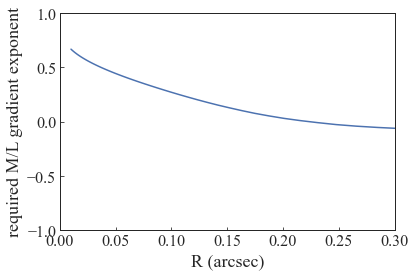

In [39]:
plt.plot(r, -(np.log((powerlaw_median - dark_median) / light_median) / np.log(r/3.2)))
plt.ylim(-1, 1)
plt.xlim(0., 0.3)
plt.xlabel('R (arcsec)')
plt.ylabel('required M/L gradient exponent')

In [77]:
print('mean M/L gradient exponent upto {:.2f} arcsec:'.format(r[43]), np.sum(-(r*(np.log((powerlaw_median - dark_median) / light_median) / np.log(r/3.2)))[:44]) / np.sum(r[:44]))

mean M/L gradient exponent upto 0.20 arcsec: 0.26890414325356615


/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [22]:
isophote_intensity_error

array([0.00000000e+00, 9.99539018e-04, 2.06876179e-03, 5.49358042e-03,
       7.29969744e-03, 9.33679397e-03, 8.69627404e-03, 9.16679514e-03,
       1.25988251e-02, 1.10466133e-02, 1.13003861e-02, 1.21331830e-02,
       1.10743969e-02, 1.11720158e-02, 1.14866162e-02, 9.92956363e-03,
       9.39634735e-03, 8.98019433e-03, 7.96205859e-03, 3.98309454e-03,
       3.48139033e-03, 4.00932211e-03, 4.54913706e-03, 3.66776834e-03,
       3.85232915e-03, 3.75455363e-03, 3.33654512e-03, 2.41597255e-03,
       2.29695979e-03, 1.93399821e-03, 1.70781409e-03, 2.05233039e-03,
       1.14011624e-03, 1.42845769e-03, 1.68362478e-03, 2.20761580e-03,
       4.51526471e-03, 1.14663780e-02, 6.52147056e-03, 2.52154950e-03,
       4.00355720e-03, 3.14034657e-03, 1.39225814e-03, 1.33138712e-03,
       8.86181516e-04, 6.89523439e-04, 5.32694097e-04, 3.53720661e-04,
       2.87723532e-04, 2.52366435e-04, 2.05439476e-04, 1.95434425e-04,
       2.21679406e-04, 1.53852892e-04, 1.41134223e-04, 9.37529636e-05,
      

75775.80421448589


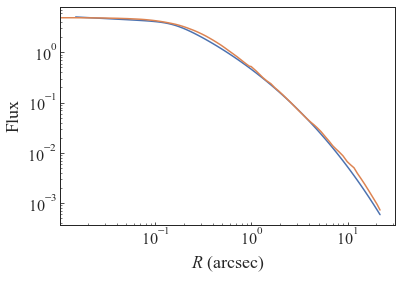

In [23]:
## fit core sersic

def core_sersic(R, R_b, alpha, gamma, R_e, n):
    """
    Definition from Dullo et al. 2019 eq. (2)
    """
    b = 1.9992*n - 0.3271
    I_ = 2**(-gamma/alpha) * np.exp(b * (2**(1/alpha) * R_b / R_e)**(1/n))
    
    I = I_ * (1 + (R_b/R)**alpha)**(gamma/alpha) * np.exp(-b * ((R**alpha + R_b**alpha)/R_e**alpha)**(1/alpha/n))
    
    return I

def plot_model(params):
    """
    """
    R_b, alpha, gamma, R_e, n = params
    model = core_sersic(isophote_r[1:], R_b, alpha, gamma, R_e, n)
        
    amp = np.sum(model * isophote_intensity[1:] / isophote_intensity_error[1:]**2) / np.sum(model**2 / isophote_intensity_error[1:]**2)
    
    plt.loglog(isophote_r[1:], amp * model, label='model')
    plt.loglog(isophote_r, isophote_intensity, label='isophote intensity profile')
    
    plt.xlabel(r'$R$ (arcsec)')
    plt.ylabel('Flux')

def chi2(params):
    """
    """
    R_b, alpha, gamma, R_e, n = params
    model = core_sersic(isophote_r[1:], R_b, alpha, gamma, R_e, n)
        
    amp = np.sum(model * isophote_intensity[1:] / isophote_intensity_error[1:]**2) / np.sum(model**2 / isophote_intensity_error[1:]**2)
    #print(amp)
    return np.sum(0.5 * (isophote_intensity[1:] - amp * model)**2 / isophote_intensity_error[1:]**2)


# test the functions
print(chi2([.15, 5, 0.1, 3.2, 4]))
plot_model([.15, 5, 0.1, 3.2, 4])

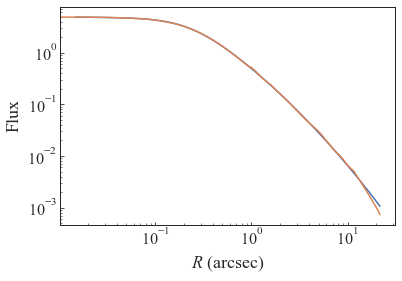

In [24]:
from scipy.optimize import minimize

res = minimize(chi2, [.15, 5, 0.1, 3.2, 4], method="Nelder-Mead", tol=1e-4, )

plot_model(res.x)

In [25]:
#res.x[0] = 42.
res.x

array([0.21173607, 2.1855336 , 0.01552691, 4.1391336 , 7.0638438 ])

In [26]:
import emcee

def log_probability(params):
    return -chi2(params)

pos = res.x + 1e-4 * np.random.randn(len(res.x)*10, len(res.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)


In [27]:
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:21<00:00, 94.46it/s] 


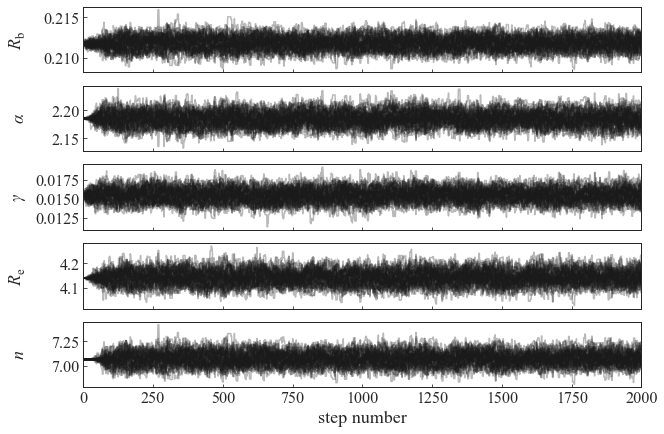

In [28]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$R_{\rm b}$", r"$\alpha$", r"$\gamma$", r"$R_{\rm e}$", r"$n$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [29]:
# R_b from chain
low, med, high = np.percentile(samples[-250:, ::50, 0], q=[16, 50, 84])

low, med, high # arcsecond

(0.21071972174160108, 0.21156393312518523, 0.2124635669493723)

In [30]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(70, 0.3)

# print R_b in kpc
cosmo.angular_diameter_distance(0.23).value * 1e3 * np.array([low, med, high])/206265

array([0.77424855, 0.77735044, 0.78065597])

## Magnification of images including central image in the composite model

In [31]:
import copy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

composite_weights = get_relative_weights(composite_bics, sigma_model_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)    

magnifications = []

for n_job in tnrange(len(composite_files), desc='Jobs:'):
    num_sample_from_job = int(num_sample * composite_weights[n_job])
    
    sampled_indices = np.random.randint(low=0, high=composite_num_param_arrays[n_job], size=num_sample_from_job)
    
    kwargs_model = copy.deepcopy(composite_kwargs_models[n_job])
    kwargs_model['additional_images_list'] = [True]
    
    lens_model = composite_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models[n_job])
    
    lens_profile = LensProfileAnalysis(lens_model)
    
    multi_band_list_out = composite_multi_band_list[n_job]
    kwargs_likelihood = composite_kwargs_likelihoods[n_job]
    
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):        
        param_array = composite_param_arrays[n_job][sampled_indices[i]]

        param_class = composite_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']
        
        
        magnifications_4_images = lens_model.magnification(
                                     kwargs_result['kwargs_ps'][0]['ra_image'], 
                                     kwargs_result['kwargs_ps'][0]['dec_image'],
                                     kwargs_result['kwargs_lens'])
        
        ra_source, dec_source = kwargs_result['kwargs_source'][0]['center_x'], kwargs_result['kwargs_source'][0]['center_y'] 
        lensEquationSolver = LensEquationSolver(lens_model)
        x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, 
                                                              kwargs_result['kwargs_lens'], 
                                                              numImages=5,
                                                              min_distance=0.1, 
                                                              search_window=50*0.1)
        
#         print(x_image, y_image)
#         print(kwargs_result['kwargs_ps'][0]['ra_image'], 
#               kwargs_result['kwargs_ps'][0]['dec_image'],)
        try:
            assert len(x_image) == 5 and len(y_image) == 5
        except:
            continue
            
        magnification_central_image = lens_model.magnification(x_image[4], y_image[4], kwargs_result['kwargs_lens'])
        
        magnifications.append(np.append(magnifications_4_images, magnification_central_image))
        #break
        
        

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/185 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Sample from job 1::   0%|          | 0/319 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/500 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/157 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/251 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/494 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11::   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
magnifications = np.array(magnifications)

for i in range(5):
    low, med, hi = np.percentile(magnifications[:, i], q=[16, 50, 84])
    print('Image {} magnification: {:.3f}+{:.3f}-{:.3f}'.format(i+1, med, hi-med, med-low))

Image 1 magnification: -1.639+0.103-0.234
Image 2 magnification: 4.015+0.176-0.317
Image 3 magnification: -3.603+0.246-0.417
Image 4 magnification: 4.792+0.315-0.326
Image 5 magnification: 0.019+0.002-0.002


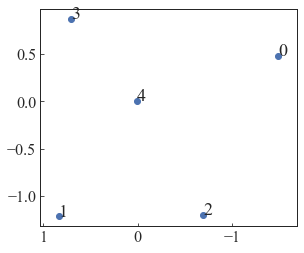

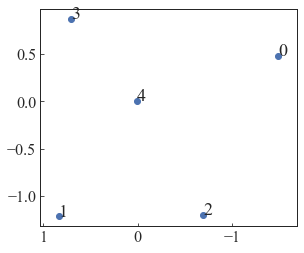

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_image, y_image)

for x, y, i in zip(x_image, y_image, range(len(x_image))):
    ax.text(x, y, '{}'.format(i))

ax.set_aspect('equal')
ax.set_xlim(x_image.max() + 0.2, x_image.min() - 0.2)

fig

Image number to letter id:
1 -> B,
2 -> C,
0 -> A,
3 -> D,
4 -> central